In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from pyevtk.hl import pointsToVTK
# import smplotlib
from scripts.halo_analysis_scripts import *
from firestudio.studios.gas_studio import GasStudio
from firestudio.studios.star_studio import StarStudio
import utilities.coordinate as utc
import iht
from glob import glob
import re
from natsort import natsorted

In [2]:
%matplotlib inline
from matplotlib.patches import Annulus
plt.rcParams['figure.dpi'] = 110
from astropy import units as un, constants as cons
plt.rcParams.update({'font.size': 15})
from scipy.stats import binned_statistic

In [100]:
df

snum   redshift   ID  hostHalo  numSubStruct          Mvir     npart  \
0     277   1.000000    0        -1           408  2.737750e+12  38074271   
1     276   1.006369    0        -1           386  2.730480e+12  37973807   
2     275   1.012780    0        -1           396  2.722850e+12  37871561   
3     274   1.019231    0        -1           398  2.713880e+12  37757478   
4     273   1.025723    0        -1           418  2.701680e+12  37610526   
..    ...        ...  ...       ...           ...           ...       ...   
259    18  10.395683   13        -1             0  1.463840e+09     17054   
260    17  10.604396   17        -1             0  1.287820e+09     14154   
261    16  10.820895   20        -1             0  1.079640e+09     11427   
262    15  11.045628  228        21             0  1.208320e+08      1026   
263    14  11.279070  228        21             0  1.208320e+08      1026   

               Xc            Yc            Zc  ...  Eaz_star  Ebx_star  \
0    47187.274917  51794.824036  51547.151871  ...  0.862187  0.887257   
1    47193.998563  51789.274982  51541.690251  ...  0.882154  0.880885   
2    47200.870303  51783.984404  51536.343028  ...  0.898715  0.862513   
3    47207.787712  51778.666920  51530.829160  ...  0.910174  0.831843   
4    47214.647188  51772.790818  51525.392602  ...  0.885098  0.807808   
..            ...           ...           ...  ...       ...       ...   
259  49175.630642  50302.559258  50205.594822  ... -0.487495 -0.284290   
260  49182.920046  50299.856957  50201.614572  ... -0.334852  0.483644   
261  49190.311005  50295.913475  50197.388979  ...  0.849869 -0.266603   
262  49189.798186  50298.043407  50203.190760  ...  0.705538  0.017807   
263  49189.798186  50298.043407  50203.190760  ...  0.705538  0.017807   

     Eby_star  Ebz_star  Ecx_star  Ecy_star  Ecz_star     Ekin_star  \
0    0.299986  0.350405 -0.424511  0.828215  0.365855  7.550840e+16   
1    0.375437  0.288253 -0.464345  0.803536  0.372443  7.562250e+16   
2    0.454708  0.222061 -0.506034  0.775196  0.378154  7.534790e+16   
3    0.535572  0.145600 -0.546007  0.742625  0.387794  7.531390e+16   
4    0.580321  0.103317 -0.557465  0.695201  0.453793  7.576750e+16   
..        ...       ...       ...       ...       ...           ...   
259  0.690090  0.665549  0.795891 -0.217175  0.565149  1.985740e+09   
260 -0.752706 -0.446680  0.538781 -0.146164  0.829669  1.351030e+09   
261  0.906651 -0.326967  0.822431  0.390886  0.413298  5.921660e+08   
262  0.760040 -0.649632  0.933449  0.220179  0.283186  7.822060e+07   
263  0.760040 -0.649632  0.933449  0.220179  0.283186  7.822060e+07   

        Epot_star  cAnalytic  
0   -1.956920e+17   4.828559  
1   -1.955650e+17   4.816297  
2   -1.952290e+17   4.804109  
3   -1.949180e+17   4.792151  
4   -1.952810e+17   4.780731  
..            ...        ...  
259 -3.200970e+09   3.200961  
260 -2.059570e+09   3.208986  
261 -9.981380e+08   3.210041  
262 -1.938430e+08   2.979911  
263 -1.938430e+08   2.988498  

[264 rows x 95 columns]

Text(0, 0.5, '$\\Delta (\\vec{x}_{\\mathrm{center}})$ [phys. kpc/h]')

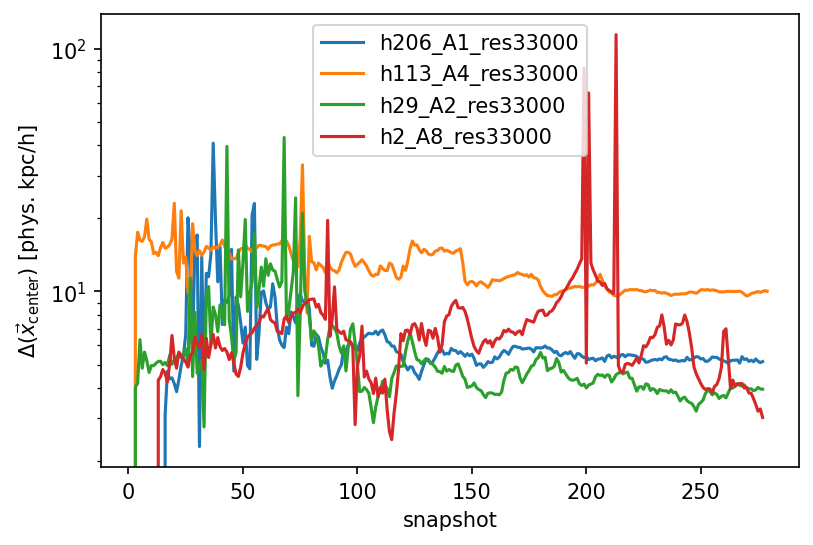

In [104]:
plt.figure(dpi=150)
for sim in ['h206_A1_res33000', 'h113_A4_res33000', 'h29_A2_res33000', 'h2_A8_res33000']:
    simdir = f'/projects/b1026/snapshots/MassiveFIRE/{sim}/halo/ahf/halo_00000_smooth.dat'
    ahf = np.genfromtxt(simdir, delimiter='\t', skip_header=True)
    
    sort_idx = np.argsort(ahf[:,0])
    snapshots = ahf[:,0][sort_idx]
    redshifts = ahf[:,1][sort_idx]
    
    centers = ahf[:,7:10][sort_idx]  #in comoving kpc/h
    centers = centers/2#(1+redshifts)[:,None] #in physical kpc/h
    
    Delta_xcenter = np.linalg.norm(centers[1:]-centers[:-1], axis=1)
    plt.plot(snapshots[1:], Delta_xcenter, label=sim)

plt.yscale('log')
plt.legend()
plt.xlabel('snapshot')
plt.ylabel(r'$\Delta (\vec{x}_{\mathrm{center}})$ [phys. kpc/h]')
# plt.ylim(60, 165)

<Figure size 900x600 with 0 Axes>

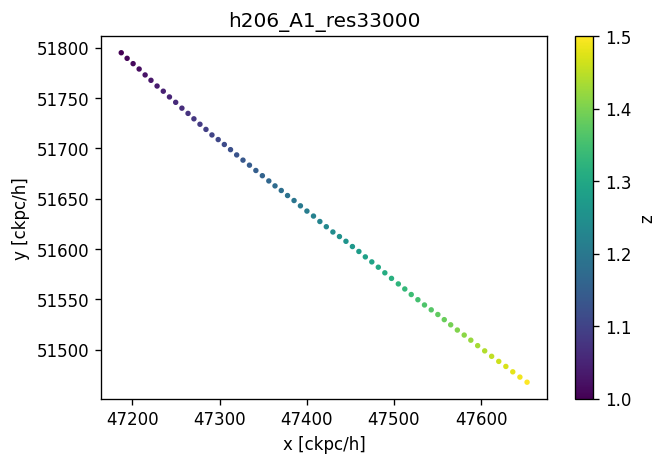

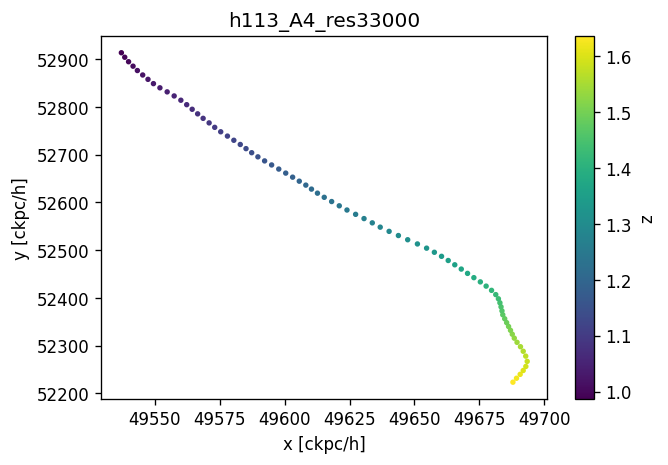

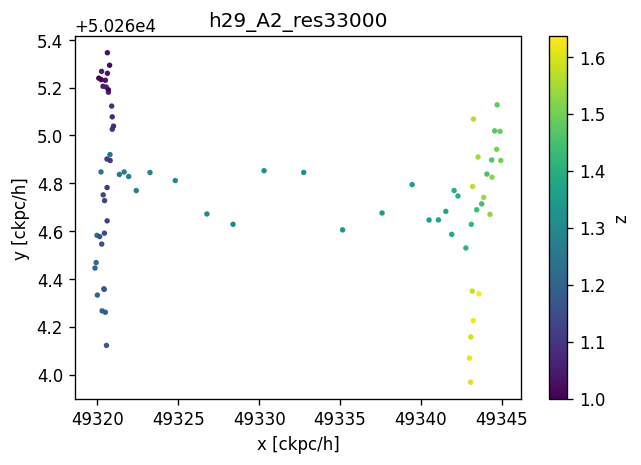

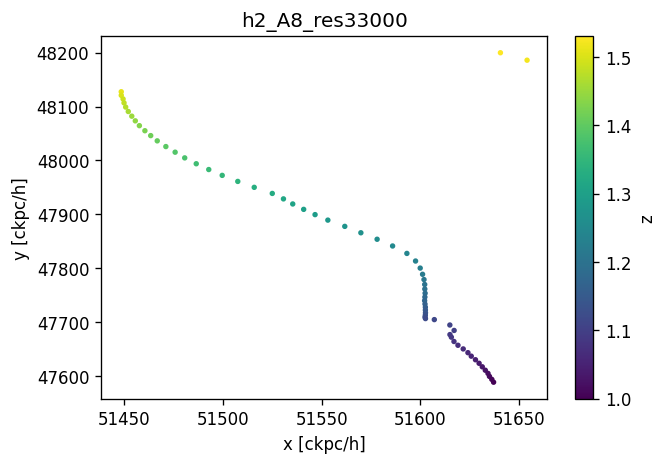

In [22]:
plt.subplots()
for sim in ['h206_A1_res33000', 'h113_A4_res33000', 'h29_A2_res33000', 'h2_A8_res33000']:
    simdir = f'/projects/b1026/snapshots/MassiveFIRE/{sim}/halo/ahf/halo_00000_smooth.dat'
    ahf = np.genfromtxt(simdir, delimiter='\t', skip_header=True)
    
    sort_idx = np.argsort(ahf[:,0])
    snapshots = ahf[:,0][sort_idx]
    redshifts = ahf[:,1][sort_idx]
    
    centers = ahf[:,7:10][sort_idx]  #in comoving kpc/h
    plt.figure(dpi=120)
    plt.scatter(centers[200:,0], centers[200:,1], c=redshifts[200:], s=5)
    plt.colorbar(label='z')
    plt.title(sim)
    plt.xlabel('x [ckpc/h]')
    plt.ylabel('y [ckpc/h]')

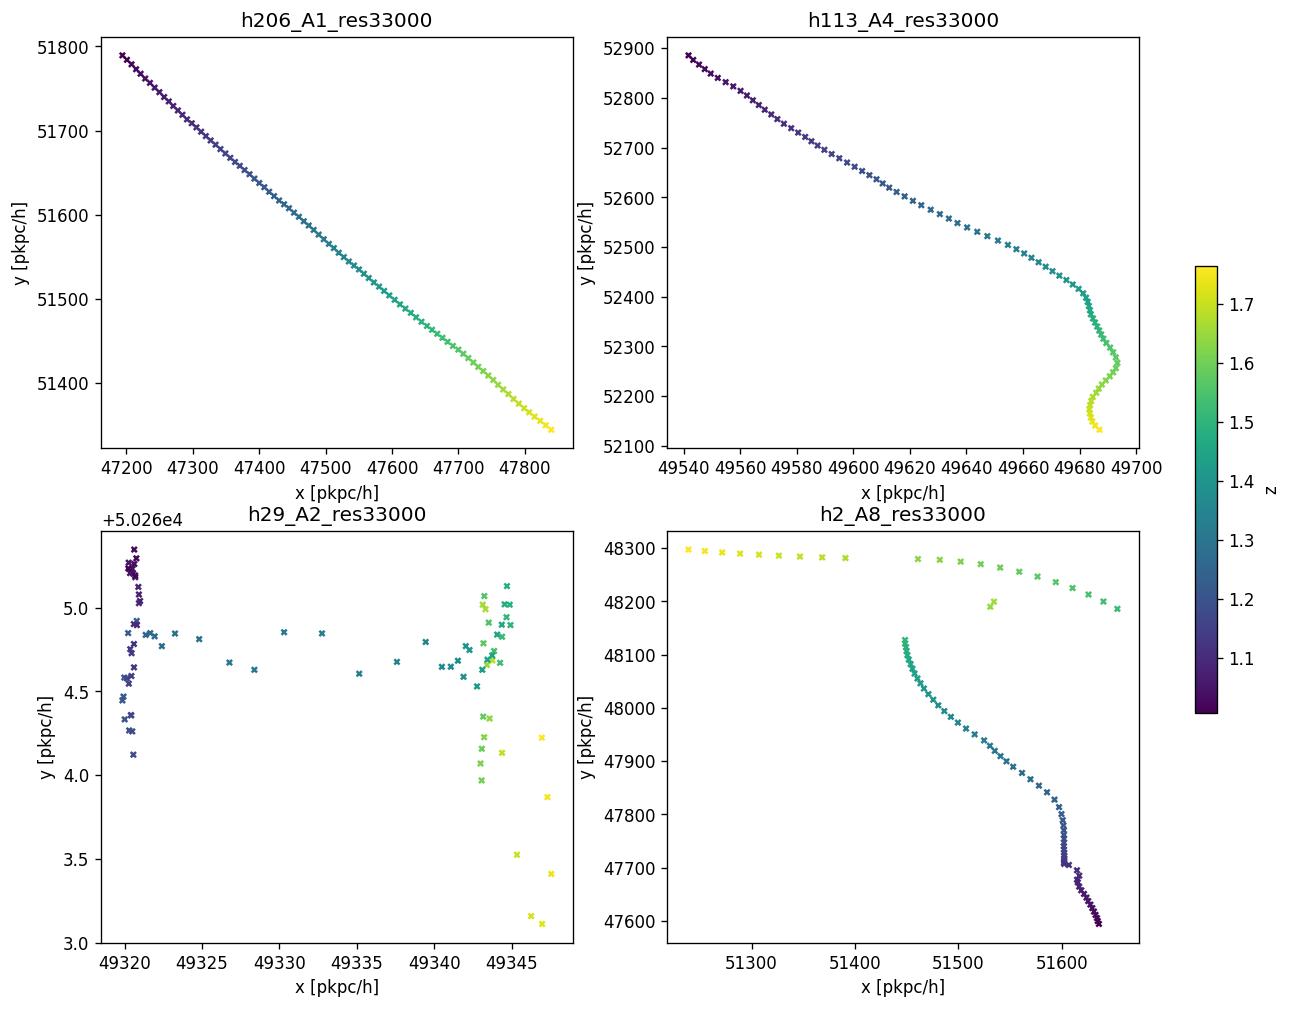

In [89]:
sims = ['h206_A1_res33000', 'h113_A4_res33000', 'h29_A2_res33000', 'h2_A8_res33000']

fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=120)

for ax, sim in zip(axs.flat, sims):
    simdir = f'/projects/b1026/snapshots/MassiveFIRE/{sim}/halo/ahf/halo_00000_smooth.dat'
    ahf = np.genfromtxt(simdir, delimiter='\t', skip_header=True)

    sort_idx = np.argsort(ahf[:,0])
    snapshots = ahf[:,0][sort_idx]
    redshifts = ahf[:,1][sort_idx]
    centers = ahf[:,7:10][sort_idx]  # in comoving kpc/h
#     centers = centers/(1+redshifts)[:,None] #in physical kpc/h

    idx = list(snapshots).index(190)
    idx2 = list(snapshots).index(277)
    sc = ax.scatter(centers[idx:idx2,0], centers[idx:idx2,1], c=redshifts[idx:idx2], s=10, marker='x', cmap='viridis')
    ax.set_title(sim)
    ax.set_xlabel('x [pkpc/h]')
    ax.set_ylabel('y [pkpc/h]')

# Add one colorbar for all subplots
cbar = fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.05)
cbar.set_label('z')


# Movies

In [3]:
from scripts.particle_tracking import load, selectparticles_zach, trackparticles, process_sim
import pickle

In [4]:
def plotviz(ax, p, simname, snapnum, cbar=False, ascale=1, boxsize=None, font_color='w', plotType='T', rotate=False, use_metadata=True, Tmin=4.5, Tmax=7, Smin=-3.5, Smax=1, edgeOn=False, figure_label=None):
    p0 = p[0]
    datadir='vizdata'
    outdir='vizimages'
    if boxsize is None: boxsize=p0['Rvir']*2.5
    frame_half_thickness=None
    print(boxsize)
    if figure_label is None: figure_label=simname
    
    if p0 is not None:
        gaspart = {}
        gaspart['Coordinates'] = p0['Coordinates'] / ascale
        gaspart['Masses'] = p0['Masses'] * 1.e10
        gaspart['Metallicity'] = p0['Metallicity']
        gaspart['SmoothingLength'] = p0['SmoothingLength'] / ascale
        gaspart['BoxSize'] = boxsize
        gaspart['Temperature'] = p0['Temperature']
        gaspart['logT'] = np.log10(p0['Temperature'])
    
        if edgeOn: gaspart['Coordinates'] = gaspart['Coordinates'][:, [2, 1, 0]]
    else:
        gaspart = None
    
    gasStudio = GasStudio(
        datadir=datadir, 
        snapnum=snapnum,
        sim_name=simname,
        gas_snapdict = gaspart,
        frame_half_width = boxsize//2,
        scale_bar=True,
        scale_line_length=200,
        figure_label=figure_label,
        figure_label_side='right',
        fontsize=16,
        font_color=font_color,
        use_colorbar=cbar,
        cbar_logspace=False,
        loud=True)
    
    if plotType=='Sigma': #Surface density map 
        gasStudio.set_ImageParams(cbar_label=r'$\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$')
        gasStudio.render(ax=ax, 
                         weight_name='Masses',
                         min_weight=Smin,
                         max_weight=Smax,
                         weight_adjustment_function= lambda x: np.log10(x/gasStudio.Acell)-6, # Msun/pc^2
                         cmap='magma_r',
                         use_metadata=use_metadata, 
                         load=True)
    elif plotType=='T': #Mass-weighted Temperature map
        if Tmin=='auto':
            idxT = (np.abs(gaspart['Coordinates'][:,0])<(boxsize/2))&(np.abs(gaspart['Coordinates'][:,1])<(boxsize/2))&(np.abs(gaspart['Coordinates'][:,2])<15)
            Tmin, Tmax = np.percentile(gaspart['logT'][idxT], [2,98])
        gasStudio.set_ImageParams(cbar_label=r'$\log (T/\mathrm{K})$')
        gasStudio.render(ax=ax, 
                         weight_name='Masses',
                         quantity_name='logT',
                         min_quantity=Tmin,
                         max_quantity=Tmax,
                         cmap='afmhot_r',
                         use_metadata=use_metadata,
                         loud=True)
    
    if p0 is not None: print(p0['Rvir'], p0['Redshift'])
    # plt.title(f"z={str(np.around(p0['Redshift'],2)).zfill(2)}, {simname}")

In [5]:
with open(f'/projects/b1026/isultan/data/rotcache/rot_{os.path.basename(os.path.normpath("h2_A8_res33000"))}_{277}.pkl', 'rb') as f: rot_tf = pickle.load(f)

In [5]:
def load_efficient(simname, snapnum, rotsnap=277):
    simdir = f'/projects/b1026/snapshots/MassiveFIRE/{simname}'
    with open(f'/projects/b1026/isultan/data/rotcache/rot_{simname}_{rotsnap}.pkl', 'rb') as f: 
        rot = pickle.load(f)
    part = load_allparticles(simdir, snapnum, [0], keys_to_extract={0:['Coordinates', 'Masses', 'Metallicity', 'SmoothingLength', 'Temperature']}, loud=0)
    part[0]['Coordinates'] -= part[0]['posC']
    part[0]['Coordinates'] = rot.apply(part[0]['Coordinates'])
    return part

In [6]:
res = Parallel(n_jobs=-1, verbose=10)(delayed(load_efficient)('h206_A1_res33000', s) for s in [67,150,277])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.8s finished


In [6]:
def make_movie_frame(simdir, simname, snapnum, rot=None, boxsize=1400, projectall=True):
    with open(f'/projects/b1026/isultan/data/rotcache/rot_{simname}_{277}.pkl', 'rb') as f: 
        rot = pickle.load(f)
    part = load_allparticles(simdir, snapnum, [0], keys_to_extract={0:['Coordinates', 'Masses', 'Metallicity', 'SmoothingLength', 'Temperature']}, loud=0)
    part[0]['Coordinates'] -= part[0]['posC']
    part[0]['Coordinates'] = rot.apply(part[0]['Coordinates'])
    if projectall: part[0]['Coordinates'][:,2] = 0
    
    for plotType in ['Sigma', 'T']:
        fig, ax = plt.subplots(1, 1, dpi=300)
        plotviz(ax, part, simname, snapnum, edgeOn=False, boxsize=boxsize,
                cbar=True, plotType=plotType, use_metadata=False, font_color='k',
#                 Tmin=2.6, Tmax=7.3, Smin=-3.5, Smax=3,
                Tmin=2.6, Tmax=7.3, Smin=-1.7, Smax=1.7,
                figure_label=f'z={part[0]["Redshift"]:.2f}',
                ascale=part[0]['ScaleFactor'])

        #Draw circle of radius Rvir
        circle = plt.Circle((0, 0), part[0]['Rvir']/part[0]['ScaleFactor'], color='w', fill=False, lw=2, alpha=0.5)
        ax.add_patch(circle)
#         circle = plt.Circle((0, 0), 0.05*part[0]['Rvir']/part[0]['ScaleFactor'], color='w', fill=False, lw=1, alpha=0.2)
#         ax.add_patch(circle)
        plt.savefig(f'/home/ias627/projects/massive_halos/notebooks/vizimages/{plotType}_{simname}_{snapnum:03}.png')

1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 67
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=5.00
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 9340409 particles
------------------------------------------
-----------------------------

/home/ias627/tools/FIRE_studio/src/firestudio/studios/gas_studio.py:766: RuntimeWarning: invalid value encountered in divide
  weightWeightedQuantityMap = weightWeightedQuantityMap/weightMap
/tmp/ipykernel_280322/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
  weight_adjustment_function= lambda x: np.log10(x/gasStudio.Acell)-6, # Msun/pc^2


18.067910090865617 4.999998812668437
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 67
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=5.00
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log (T/\mathrm{K})$
projecting 9340409 particles
------------------------------------------
------------------------------------------


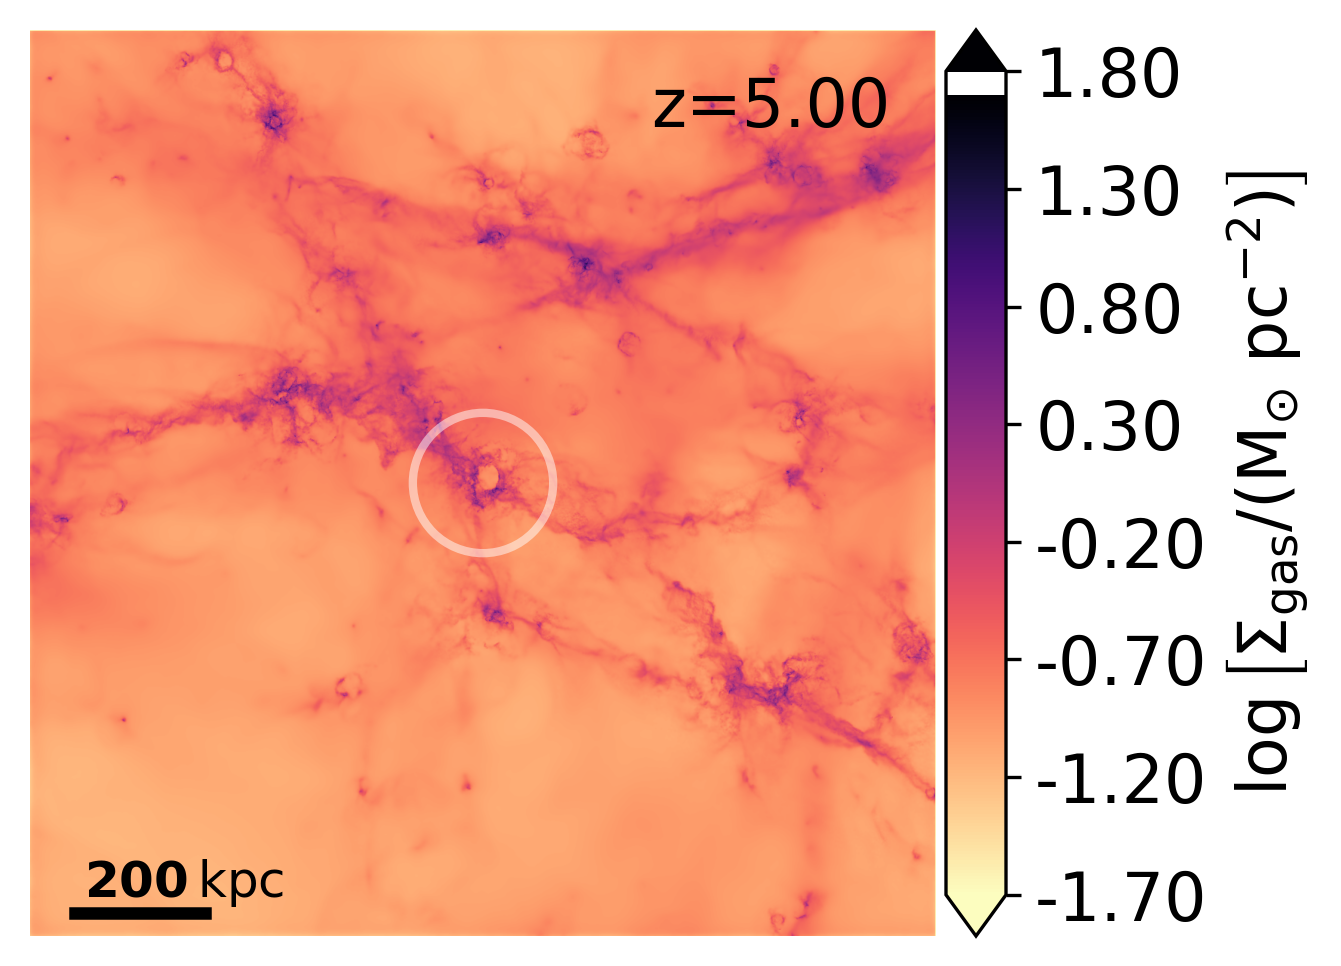

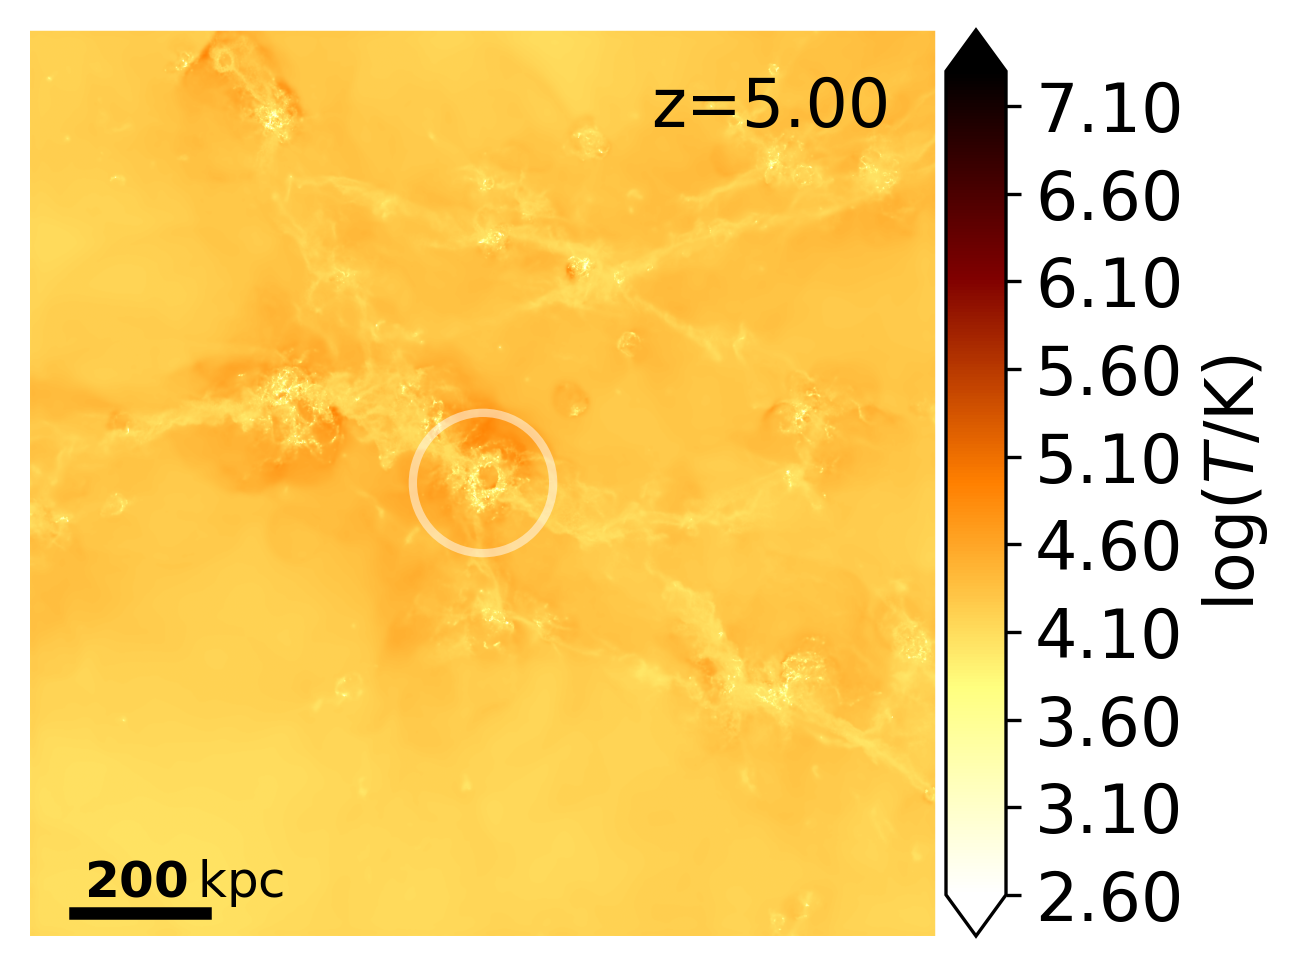

In [11]:
make_movie_frame('/projects/b1026/snapshots/MassiveFIRE/h2_A8_res33000',
                'h2_A8_res33000',
                67)

900
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 212
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=1.52
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 55277804 particles
------------------------------------------
----------------------------

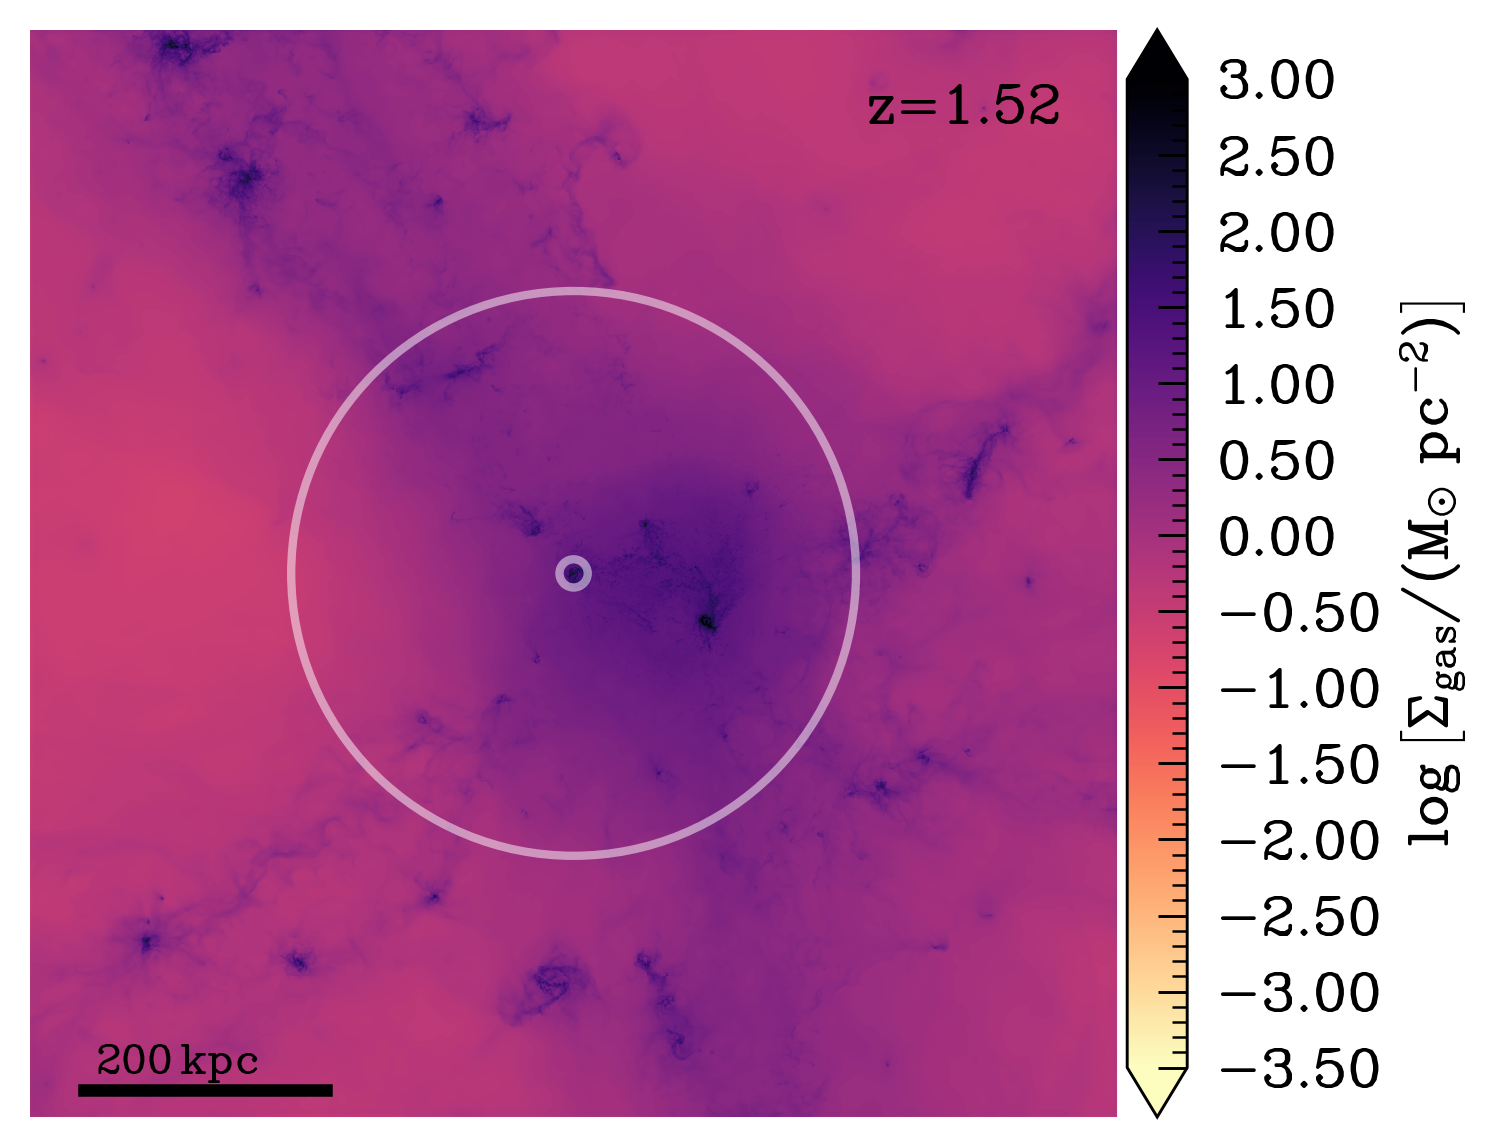

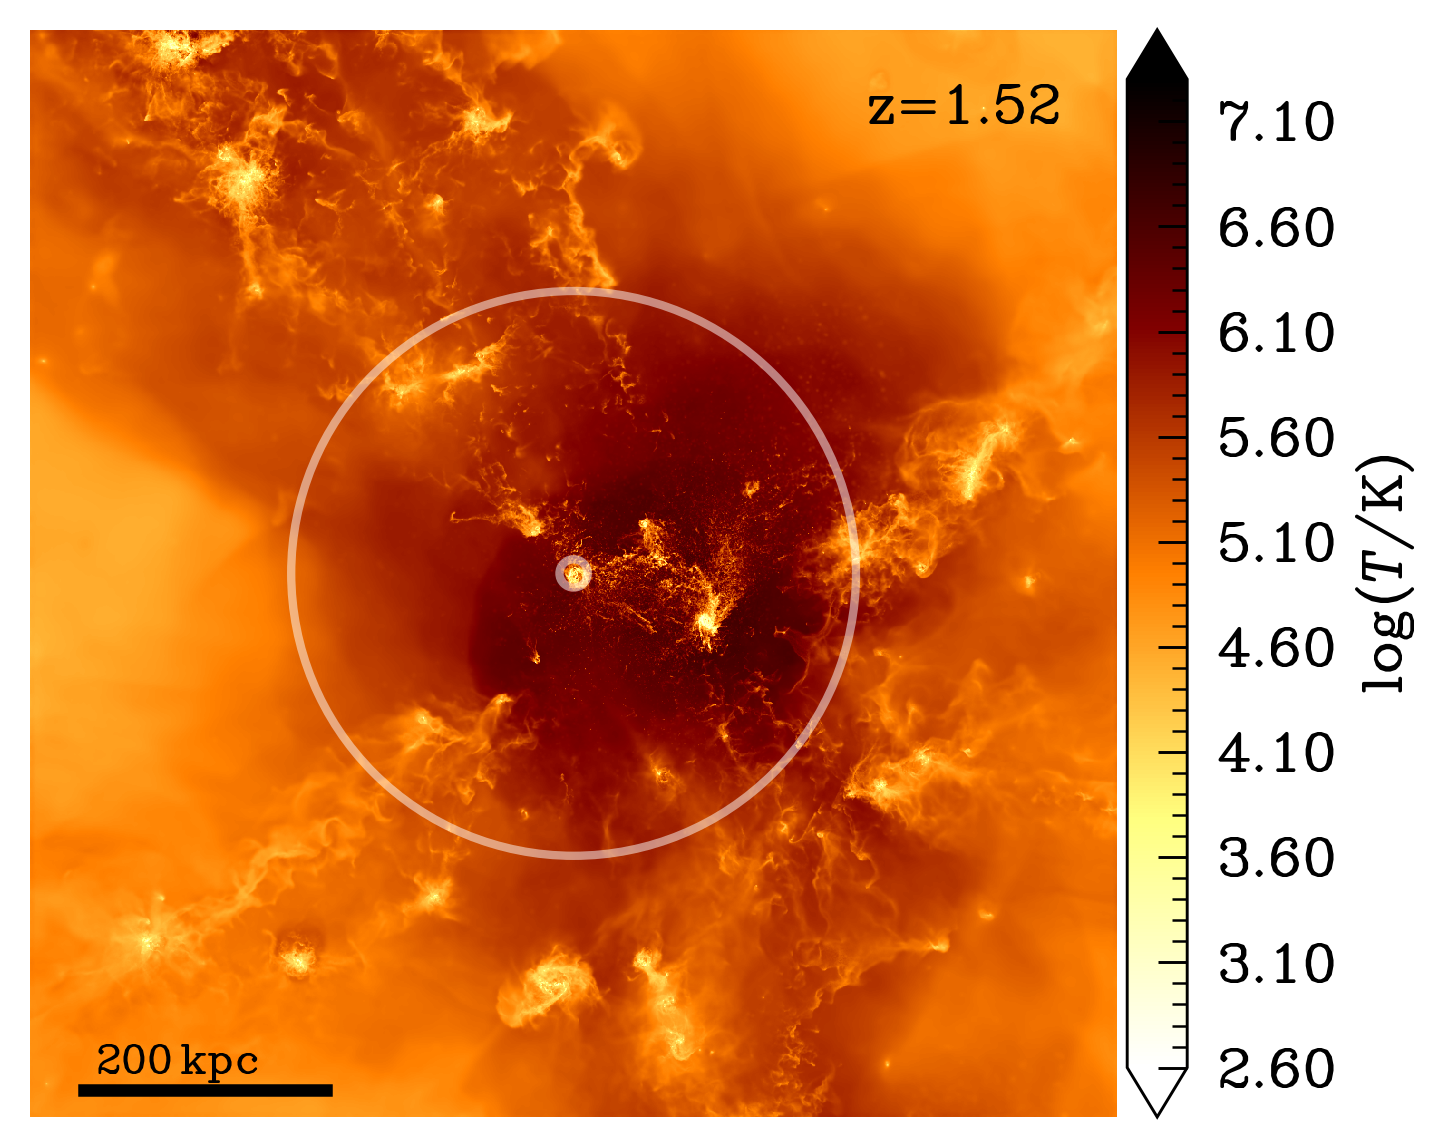

In [14]:
make_movie_frame('/projects/b1026/snapshots/MassiveFIRE/h2_A8_res33000',
                'h2_A8_res33000',
                212,
                rot_tf)

In [7]:
for simname in ['h206_A1_res33000', 'h113_A4_res33000', 'h29_A2_res33000', 'h2_A8_res33000']:
    n_jobs = 30 if simname in ['h113_A4_res33000', 'h29_A2_res33000'] else 10 if simname == 'h2_A8_res33000' else -1
    Parallel(n_jobs=n_jobs, verbose=False)(delayed(make_movie_frame)(f'/projects/b1026/snapshots/MassiveFIRE/{simname}', simname, s) for s in range(67,278))

/home/ias627/tools/FIRE_studio/src/firestudio/studios/gas_studio.py:766: RuntimeWarning: invalid value encountered in divide
  weightWeightedQuantityMap = weightWeightedQuantityMap/weightMap
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/home/ias627/tools/FIRE_studio/src/firestudio/studios/gas_studio.py:766: RuntimeWarning: invalid value encountered in divide
  weightWeightedQuantityMap = weightWeightedQuantityMap/weightMap
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/home/ias627/tools/FIRE_studio/src/firestudio/studios/gas_studio.py:766: RuntimeWarning: invalid value encountered in divide
  weightWeightedQuantityMap = weightWeightedQuantityMap/weightMap
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/home/ias627/tools/FIRE_studio/src/firestudio/studios/gas_studio.py:766: RuntimeWarning: invalid value encountered in divide
  weightWeightedQuantityMa

1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 68
setting sim_name to user value of: h206_A1_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=4.94
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 8859937 particles
------------------------------------------
---------------------------

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 74
setting sim_name to user value of: h206_A1_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=4.62
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 8774524 particles
------------------------------------------
---------------------------

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

to default value of: 
setting snapnum to user value of: 228
setting sim_name to user value of: h206_A1_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=1.37
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 15360356 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 180722130.0
Fraction deposited: 0.9999974
minmax(weightWeightedQuantityMap

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

setting snapnum to user value of: 223
setting sim_name to user value of: h206_A1_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=1.41
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 15200800 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 153706600.0
Fraction deposited: 0.999998
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_p

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

to default value of: 
setting snapnum to user value of: 255
setting sim_name to user value of: h206_A1_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=1.15
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 15802945 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 86690590.0
Fraction deposited: 0.9999994
minmax(weightWeightedQuantityMap)

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

 True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=3.41
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 13349911 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 98415760.0
Fraction deposited: 0.9998968
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 128.80 s elapsed
min_Masses =  -1.7
max_Masses =  1

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10



setting scale_line_length to user value of: 200
setting figure_label to user value of: z=2.85
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 15743910 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 115753510.0
Fraction deposited: 0.9999983
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 132.33 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
I

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=2.80
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 15928099 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 296914980.0
Fraction deposited: 0.99994147
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 130.75 s elapsed
min_Masses =  -

/tmp/ipykernel_282204/1337704874.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


setting scale_line_length to user value of: 200
setting figure_label to user value of: z=2.69
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 16345107 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 84732310.0
Fraction deposited: 0.9999938
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 130.87 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Ima

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=2.53
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 16907883 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 88465784.0
Fraction deposited: 0.99999934
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 129.02 s elapsed
min_Masses =  -1

/tmp/ipykernel_282204/1337704874.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/tmp/ipykernel_282204/1337704874.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=2.61
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 16651063 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 109470120.0
Fraction deposited: 0.9999955
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 129.47 s elapsed
min_Masses =  -1

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=2.34
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 17354285 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 790906430.0
Fraction deposited: 0.99996984
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 132.08 s elapsed
min_Masses =  -

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


setting scale_line_length to user value of: 200
setting figure_label to user value of: z=2.28
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 17622404 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 147758050.0
Fraction deposited: 0.9999032
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 132.32 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Im

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=2.41
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 17115829 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 527766180.0
Fraction deposited: 0.9999977
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 132.19 s elapsed
min_Masses =  -1

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter


setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 22248181 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 204802240.0
Fraction deposited: 0.999999
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 116.19 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.1774416
Image range (8bit):  0.0 255.0
205.48780781358894 1.470588

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 23556432 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 165661740.0
Fraction deposited: 1.000001
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 122.81 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.085329
Image range (8bit):  0.0 255.0
222.5438947239126 1.2909092826589221
1400
setting use_c

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 11739664 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 146765710.0
Fraction deposited: 0.99994636
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 134.77 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.032732
Image range (8bit):  0.0 255.0
78.54877970231708 3.705882372065383
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 10158735 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 327603420.0
Fraction deposited: 0.9999984
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 132.39 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.3814554
Image range (8bit):  0.0 255.0
55.75851135768403 4.431034025156529
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 13369592 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 251652160.0
Fraction deposited: 0.99998087
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 136.25 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.2669077
Image range (8bit):  0.0 255.0
97.60329881949292 3.155844173263173
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnu

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 13989349 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 199294750.0
Fraction deposited: 0.99992627
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 138.19 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.1656027
Image range (8bit):  0.0 255.0
109.7349892474496 2.8518516246639933
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value 

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 12274073 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 128482080.0
Fraction deposited: 0.9996181
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 139.87 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 1.9749494
Image range (8bit):  0.0 255.0
83.77248461211357 3.5390071092173496
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value o

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 12579468 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 290469980.0
Fraction deposited: 0.9999056
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 139.83 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.3292084
Image range (8bit):  0.0 255.0
90.38549132106495 3.3537415263880375
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to 

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 12420047 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 104688720.0
Fraction deposited: 0.9998123
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 136.49 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 1.8860068
Image range (8bit):  0.0 255.0
84.81545823581405 3.507042273716797
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default v

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 16672149 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 194209380.0
Fraction deposited: 0.9998068
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 125.20 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.154377
Image range (8bit):  0.0 255.0
146.1540310760662 2.233160332790377
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 157
setting sim_name to user value of: h29_A2_res33000
setting scale_bar to user value of: True
settin

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 19601726 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 174519070.0
Fraction deposited: 0.9999922
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 140.94 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.1079502
Image range (8bit):  0.0 255.0
175.11812568805144 1.9032261861015547
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 179
setting sim_name to user value of: h29_A2_res33000
setting scale_bar to user value of: True
set

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 21129742 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 330011460.0
Fraction deposited: 0.9999943
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 132.18 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.384636
Image range (8bit):  0.0 255.0
187.68226771329282 1.7876103184895218
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 188
setting sim_name to user value of: h29_A2_res33000
setting scale_bar to user value of: True
setting scale_line_length

/home/ias627/tools/FIRE_studio/src/firestudio/studios/gas_studio.py:766: RuntimeWarning: invalid value encountered in divide
  weightWeightedQuantityMap = weightWeightedQuantityMap/weightMap
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/home/ias627/tools/FIRE_studio/src/firestudio/studios/gas_studio.py:766: RuntimeWarning: invalid value encountered in divide
  weightWeightedQuantityMap = weightWeightedQuantityMap/weightMap
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/home/ias627/tools/FIRE_studio/src/firestudio/studios/gas_studio.py:766: RuntimeWarning: invalid value encountered in divide
  weightWeightedQuantityMap = weightWeightedQuantityMap/weightMap
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/home/ias627/tools/FIRE_studio/src/firestudio/studios/gas_studio.py:766: RuntimeWarning: invalid value encountered in divide
  weightWeightedQuantityMa

1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 75
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=4.58
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 9973508 particles
------------------------------------------
-----------------------------

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 73
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=4.68
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 9815566 particles
------------------------------------------
-----------------------------

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

to user value of: 97
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=3.67
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 11896782 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 40571356.0
Fraction deposited: 0.99999887
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(Gas

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: 101
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=3.54
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 12194906 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 127909570.0
Fraction deposited: 0.9999998
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(Ga

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: 102
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=3.51
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 12265696 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 114710690.0
Fraction deposited: 0.99999887
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(G

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: 103
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=3.48
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 12336927 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 92639680.0
Fraction deposited: 0.9999983
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(Gas

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

to user value of: 200
setting figure_label to user value of: z=2.78
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 14275757 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 85367190.0
Fraction deposited: 0.99999774
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 138.22 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: 200
setting figure_label to user value of: z=2.76
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 14346666 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 63376628.0
Fraction deposited: 0.99999857
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 145.60 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: 200
setting figure_label to user value of: z=2.71
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 14499541 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 100798280.0
Fraction deposited: 0.9999956
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 144.63 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: 200
setting figure_label to user value of: z=2.67
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 14617270 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 186266140.0
Fraction deposited: 0.99999774
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 146.73 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/1337704874.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/tmp/ipykernel_282204/1337704874.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/tmp/ipykernel_282204/1337704874.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly

setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 15930169 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 168949780.0
Fraction deposited: 0.9999992
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 144.48 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.0938644
Image range (8bit):  0.0 255.0
114.71933285509326 2.200000001058719
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 15773467 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 135562820.0
Fraction deposited: 0.99999905
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 143.33 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 1.9982476
Image range (8bit):  0.0 255.0
113.85893917697918 2.216495216873038
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value 

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 16114892 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 83392680.0
Fraction deposited: 0.99999946
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 141.27 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 1.7872348
Image range (8bit):  0.0 255.0
115.52394768071693 2.18367310735705
1400
setting use_colorbar to user value of: True
setting c

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 16546834 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 128256030.0
Fraction deposited: 0.9999973
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 145.99 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 1.9741845
Image range (8bit):  0.0 255.0
117.03964614111833 2.15151508077938
1400
setting use_colorbar to user value of: True
setting c

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 16970779 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 132969420.0
Fraction deposited: 0.99999887
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 140.30 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 1.9898586
Image range (8bit):  0.0 255.0
118.48857741971085 2.1200002009569814
1400
setting use_colorbar to user value of: True
settin

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 17442694 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 145827900.0
Fraction deposited: 0.99999887
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 146.34 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.0299473
Image range (8bit):  0.0 255.0
119.91961930224025 2.089109376450676
1400
setting use_colorbar to user value of: True
setting cbar_logspace to

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

 aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 31049319 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 354511070.0
Fraction deposited: 0.99999124
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 151.85 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.4157372
Image range (8bit):  0.0 255.0
129.2530326186149 1.7999996702339836
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 187
setting sim_name to user value of: h2_A8_re

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 31379872 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 621061250.0
Fraction deposited: 0.9999962
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 148.89 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.6592407
Image range (8bit):  0.0 255.0
129.2530326186149 1.7876103010793658
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 188
setting sim_name to user value of: h2_A8_res3

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 31684234 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 340540220.0
Fraction deposited: 0.99999833
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 153.38 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.3982754
Image range (8bit):  0.0 255.0
129.2530326186149 1.775330093991454
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnu

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 32067729 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 292874200.0
Fraction deposited: 0.9999978
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 151.26 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.3327885
Image range (8bit):  0.0 255.0
129.2530326186149 1.763157604259273
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 32359279 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 641911000.0
Fraction deposited: 0.9999965
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 153.67 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.6735811
Image range (8bit):  0.0 255.0
129.2530326186149 1.751091431221485
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 33331930 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 471010140.0
Fraction deposited: 0.9999515
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 155.46 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.5391378
Image range (8bit):  0.0 255.0
129.25303261861487 1.7038624464709873
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapn

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 37638596 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 387654270.0
Fraction deposited: 0.999997
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 150.29 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.4545517
Image range (8bit):  0.0 255.0
261.88153684221015 1.4705882668047177
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 217
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user val

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 37821362 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 291548770.0
Fraction deposited: 0.9999972
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 149.15 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.3308182
Image range (8bit):  0.0 255.0
263.4332171893148 1.4609375436223493
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 218
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 38468821 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 207223250.0
Fraction deposited: 0.9999949
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 154.24 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.1825457
Image range (8bit):  0.0 255.0
269.78752733540904 1.4230770017491614
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 222
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
sett

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 39007796 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 323966140.0
Fraction deposited: 0.99999934
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 158.61 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.376607
Image range (8bit):  0.0 255.0
275.28422969291574 1.395437362884723
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 225
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setti

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encounter

$\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 42728094 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 177188350.0
Fraction deposited: 0.99999964
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 151.70 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.114542
Image range (8bit):  0.0 255.0
307.9038058155978 1.202796979951668
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 248
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=1.20
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font

/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
/tmp/ipykernel_282204/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10


$\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
projecting 42532110 particles
------------------------------------------
------------------------------------------
minmax(weightMap) 0.0 260284420.0
Fraction deposited: 0.9999986
minmax(weightWeightedQuantityMap) 0.0 0.0
-done
inner_projectAlongLOS(GasStudio instance, None, 'Masses', None, 'Temperature'){} 154.52 s elapsed
min_Masses =  -1.7
max_Masses =  1.7
Image range (Masses):  -inf 2.2815552
Image range (8bit):  0.0 255.0
306.6649608568574 1.2105260870160568
1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 247
setting sim_name to user value of: h2_A8_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=1.21
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting fon

1400
setting use_colorbar to user value of: True
setting cbar_logspace to user value of: False
setting cbar_label to default value of: 
setting snapnum to user value of: 276
setting sim_name to user value of: h206_A1_res33000
setting scale_bar to user value of: True
setting scale_line_length to user value of: 200
setting figure_label to user value of: z=1.00
setting figure_label_side to user value of: right
setting fontsize to user value of: 16
setting font_color to user value of: k
setting camera to user value of: Camera(pos=array([ 0.,  0., 15.]),focus=array([0., 0., 0.]))
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting noaxis to default value of: True
setting savefig to default value of: None
setting snapdir to default value of: None
setting cbar_label to user value of: $\log \left[ \Sigma_{\mathrm{gas}}/(\mathrm{M_{\odot}\ pc^{-2}})\right]$
cache npix1200_half_width700.00kpc_zmin0.00kpc_zmax30.00kpc_camera_0.00_0.00_15.00_0.00_0.00_0.00_

/tmp/ipykernel_280322/3410697278.py:46: RuntimeWarning: divide by zero encountered in log10
  weight_adjustment_function= lambda x: np.log10(x/gasStudio.Acell)-6, # Msun/pc^2


246.7575322812052 1.0000000007662364


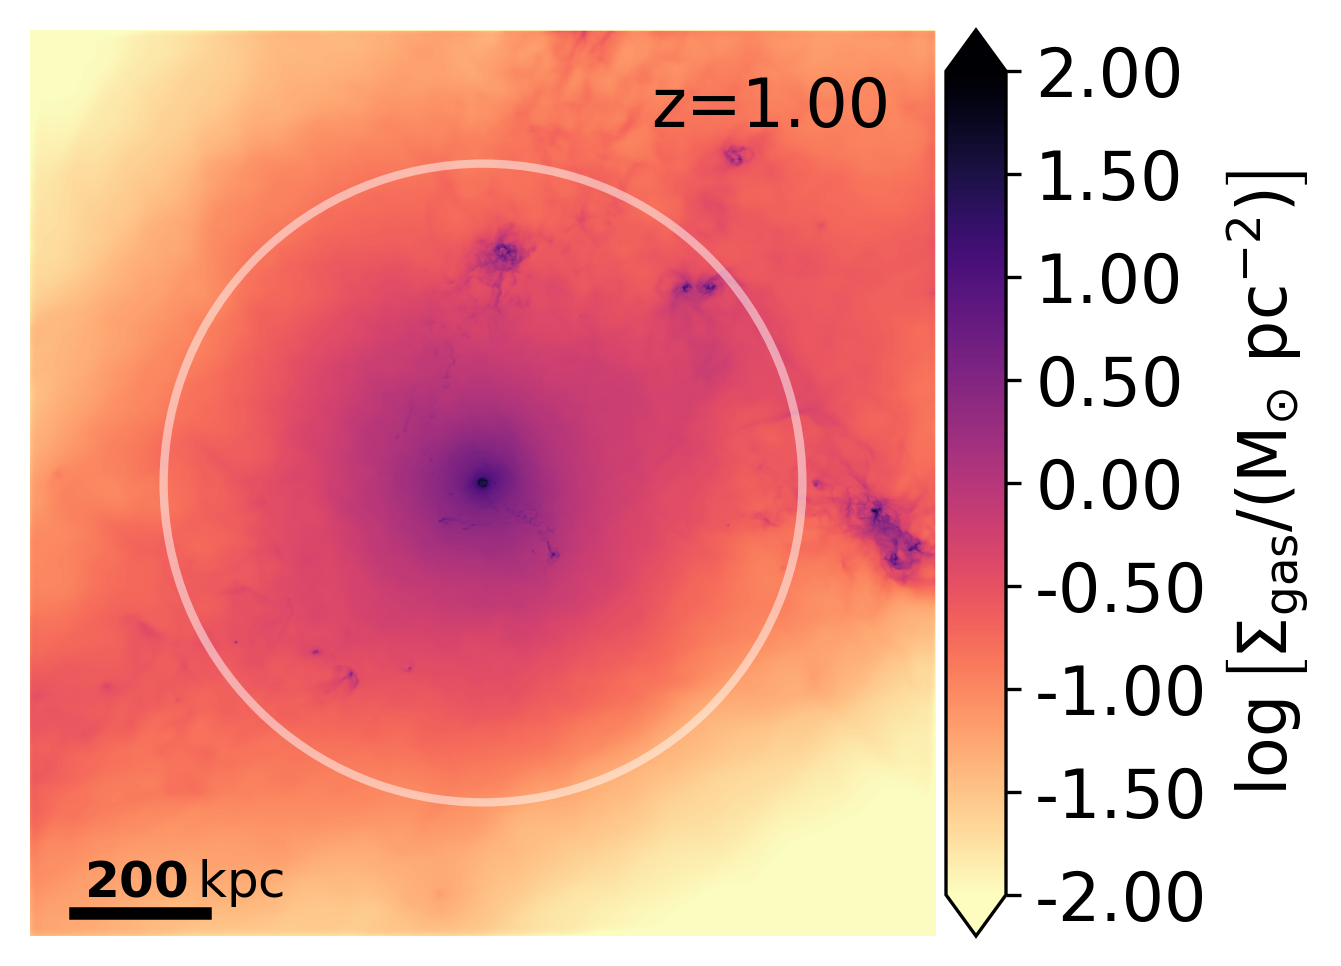

In [9]:
part = res[2]
simname = 'h206_A1_res33000'
snapnum = 276
part[0]['Coordinates'][:,2] = 0

for plotType in ['Sigma', 'T'][:1]:
    fig, ax = plt.subplots(1, 1, dpi=300)
    plotviz(ax, part, simname, snapnum, edgeOn=False, boxsize=1400,
            cbar=True, plotType=plotType, use_metadata=True, font_color='k',
#             Tmin=1.5, Tmax=7, Smin=1, Smax=4)
            Tmin=2.6, Tmax=7.3, Smin=-2, Smax=2,
            figure_label=f'z={part[0]["Redshift"]:.2f}',
            ascale=part[0]['ScaleFactor'])

    #Draw circle of radius Rvir
    circle = plt.Circle((0, 0), part[0]['Rvir']/part[0]['ScaleFactor'], color='w', fill=False, lw=2, alpha=0.5)
    ax.add_patch(circle)